<div style="text-align: center;padding-top:10px;padding-bottom:10px">
    <a href="https://geostatisticslessons.com/" target="_blank" style="color:#93c6c7" >
    <img src="https://geostatisticslessons.com/favicon-96x96.png" alt="Geostatistics Lessons Link" style="width:100px">
    </a>
</div>

<div style="text-align: center">
    <h1 style="color:#00797C;padding-bottom:0px">Transforming Data to a Gaussian Distribution</h1>
    <h2 style="color:#00797C;padding-bottom:20px">A Companion Notebook to Geostatistics Lessons</h2>    
</div>

<p class="author" style="padding: 0;"><center><b>Haoze Zhang, Ben Harding and Ryan Barnett</b></center></p>
<p class="date" style="padding: 0;"><center><b>February 24, 2025</b></center></p>

---

# Outline

The following notebook provides a demonstration of theory presented in [Transforming Data to a Gaussian Distribution](https://geostatisticslessons.com/lessons/normalscore). Transforming data to Gaussian space is a fundamental step in most simulation workflows. This notebook demonstrates the steps of transforming data to a Gaussian Distribution. Simulation results are compared for Gaussian transformations using different despiking methodologies, as well as using a smoothed kernel density estimate (KDE) of the distribution to define the transform with sparse data.

1. **Basic demonstration of the normal score transform**
    - Demonstrate the straightforward application the normal score (NS) transform
    - Visualize the anamorphosis between original and Gaussian units
    - Subsequent sections demonstrate more details around related declustering, despiking, KDE smoothing, etc.
    
3. **Declustering and despiking**
    - Initialize a grid to facilitate declustering (and simulation in later sections)
    - Use inverse distance weighting (IDW) to decluster data; the influence of declustering is inspected
    - Despike data using both spatial and random methodologies 
    
    
4. **Normal score transform with each despiking approach**
    - Run the NS transform on data depiked using different methodologies in Step (2)
    - Compare the variograms of the normal scores associated with each despiking approach
    - Spatially despiked data is shown to not introduce spatial noise, and is selected for use in simulation
    
5. **Simulation and KDE smoothing**
    - The empirical cumulative distribution function (CDF) of sparse data sets may show piecewise linear (stepping) features related to data sparsity
    - The CDFs of the back transformed realizations may reproduce these piecewise features and therefore yield sparsity-related artifacts in the results
    - To address this concern, a KDE is fit to the empirical CDF of the composites. The fit KDE is then used as a reference distribution in the NS transform. Simulation proceeds using the KDE NS transformed data, and the back-transformed realizations are shown to have no piecewise artifacts.


The presented workflow may be extended to represent other deposits. Inline annotations with each step will note practical adjustments that may be necessary for this extension.

---

Import required packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rmsp

Activate RMSP and setup global parameters. Set `show_static` to False for interactive viewer.

In [2]:
rmsp.activate()
rmsp.GlobalParams['plotting.viewer3d.show_static'] = True
rmsp.GlobalParams["core.warn_no_wt"] = False

License cleq45ynq00hqgomxnox1w5wo checked out by ryan@resmodsol.com to clhpc9e08024vlb2mj25gvz0b expires in 48 minutes. RMSP is up to date!


Define variable plotting parameters for original and normal score units, mapping variable names that will utilize them. **This section therefore relates to plotting details and could be ignored, aside from noting that `au`, `au_rd`, etc. are objects that specify plotting parameters and data column names.** E.g.:

* au specifies the column `'Au'` and original unit plotting parameters
* au_rd specifies the column `'Au with Random Despiking'` and original unit plotting parameters
* ns_rd specifies the column `'NS Au with Random Despiking'` and normal score plotting parameters

A standard camera angle applied with 3D views is also set.

In [3]:
# Original units
au = rmsp.Variable("Au").set_variable_params(
    cmap="Spectral_r",
    cmap_log=True,
    clim=(0.1, 10.0),
    axis_lim=(0.08, 10.0),
    axis_log=True,
    sigdigs=3,
)
au_rd = au.clone("Au with Random Despiking")
au_sd = au.clone("Au with Spatial Despiking")
au_kde = au.clone("Au with KDE")

# Gaussian units
ns_au = rmsp.Variable("NS_Au").set_variable_params(
    clim=(-2.5, 2.5), axis_lim=(-3.0, 3.0), sigdigs=3
)
ns_rd = ns_au.clone("NS Au with Random Despiking")
ns_sd = ns_au.clone("NS Au with Spatial Despiking")
ns_kde = ns_au.clone("NS Au with KDE")

# Camera angle/position
view_matrix = [19598.03, 18321.50, 601.65, 19991.50, 18770.10, 191.51, 0.24, 0.53, 0.81]

---
# Basic Demonstration of the Normal Score Transform

_This section demonstrates a straightforward application of the transformation; despiking and declustering should be applied in almost all scenarios_. 

Load the data:

In [4]:
data = rmsp.load_example_data("ccg_dh")
data.head()

,dh,from,to,Au,Cu,Au:shell,Cu:shell,x,startx,endx,y,starty,endy,z,startz,endz
0,1,0.0,10.0,0.07813,50.0000,0,0,19975.17140,19973.67900,19976.66481,18698.03738,18695.71500,18700.35910,210.08515,214.25400,205.91630
1,1,10.0,20.0,0.09100,33.0000,0,0,19978.16031,19976.66481,19979.65898,18702.68004,18700.35910,18705.00006,201.74776,205.91630,197.57985
2,1,20.0,30.0,0.98800,97.0001,0,0,19981.15980,19979.65898,19982.66176,18707.31872,18705.00006,18709.63554,193.41195,197.57985,189.24345
3,1,30.0,40.0,0.36400,66.0000,0,0,19984.16391,19982.66176,19985.66527,18711.95238,18709.63554,18714.27108,185.07502,189.24345,180.90733
4,1,40.0,50.0,0.48100,58.0000,0,0,19987.16587,19985.66527,19988.66572,18716.59094,18714.27108,18718.91128,176.74003,180.90733,172.57272


Perform the transform:

In [5]:
data[ns_au] = rmsp.NSTransformer(warn_no_wt=False).fit_transform(data[au], seed=515151)
data[[au, ns_au]].head()

,Au,NS_Au
0,0.07813,-1.080702
1,0.09100,-1.004758
2,0.98800,0.909150
3,0.36400,0.008400
4,0.48100,0.211574


Inspect the histograms of original and Gaussian units:

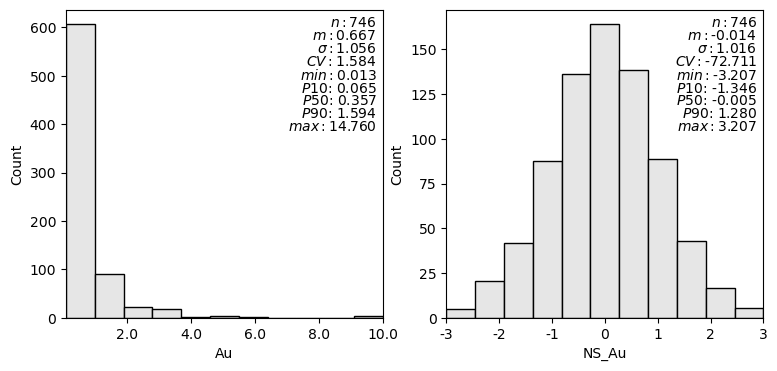

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
data.histplot(au, log=False, ax=axes[0])
data.histplot(ns_au, ax=axes[1])

Visualize the non-linear anamorphosis between the original data values and the corresponding Gaussian values:

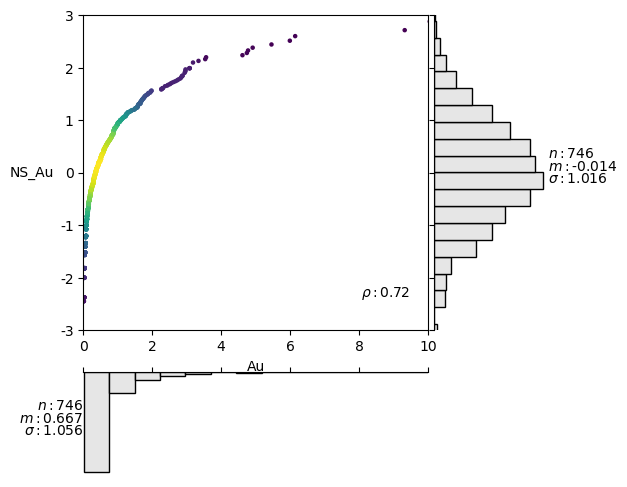

In [7]:
bivstats = rmsp.BivStats(data, variables=[ns_au.col, au.col])
fig = bivstats.scatplots(
    data,
    s=5,
    plot_marginals=True,
    logs={au.col: False},
    lims={au.col: (0, 10)},
    figsize=(6, 6),
	histplot_kwargs={"num_bin":20}
)

---
# Declustering and Despiking

Declustering and despiking are important considerations for defining a normal score transformation.

1. Declustering results in a more representative distribution of the dataset, accounting for the spatial bias typically observed in earth science data.
2. Despiking accounts for multiple data having the same numerical value, or "spikes" in the data. These values often occur at analytical detection limits, such as the minimum or maximum detection values on an assay. Two general approaches are discussed and applied: random and blended random+spatial:

     - **Random**: Randomly break ties, however this may introduce artificial variability. Although very small numbers added for breaking the ties, so that spatial structure is not altered in original units, the difference between values will grow after transforming the data and could meaningfully reduce continuity in normal score units.
     - **Blended**: Best practice (Prades, 2017) dictates a blended despiking approach which combines a random component with a local spatial neighbourhood component, resulting in transformed values that align with their local neighbourhood.

[Prades, C. (2017) Geostatistics and Clustering for Geochemical Data Analysis, M.Sc. Thesis, University of Alberta](https://era.library.ualberta.ca/items/ff2b2120-f642-46e6-9cfa-2b0dbc81ef8d/view/75ea3751-f7dc-4383-a56f-c9c00b5b7b71/Prades_Carlos_201709_Msc.pdf)

## Create a grid to facilitate declustering
Create the grids from scattered points. This grid is 5x5x5m with azimuth of 0 degrees. The search radius is 100m which will allocate blocks within 100m of the composite data. This grid is used for declustering and simulation.

In [8]:
grids = rmsp.GridData.from_scattered_points(data, usize=5, vsize=5, zsize=5, srch_radius=100)
grids.griddef.to_table()

,Easting,Northing,Elevation
minimum (m),19791.77,18509.76,106.06
maximum (m),20191.77,19039.76,281.06
size (m),5.0,5.0,5.0
number,80,106,35


Plot the inferred grid and data:

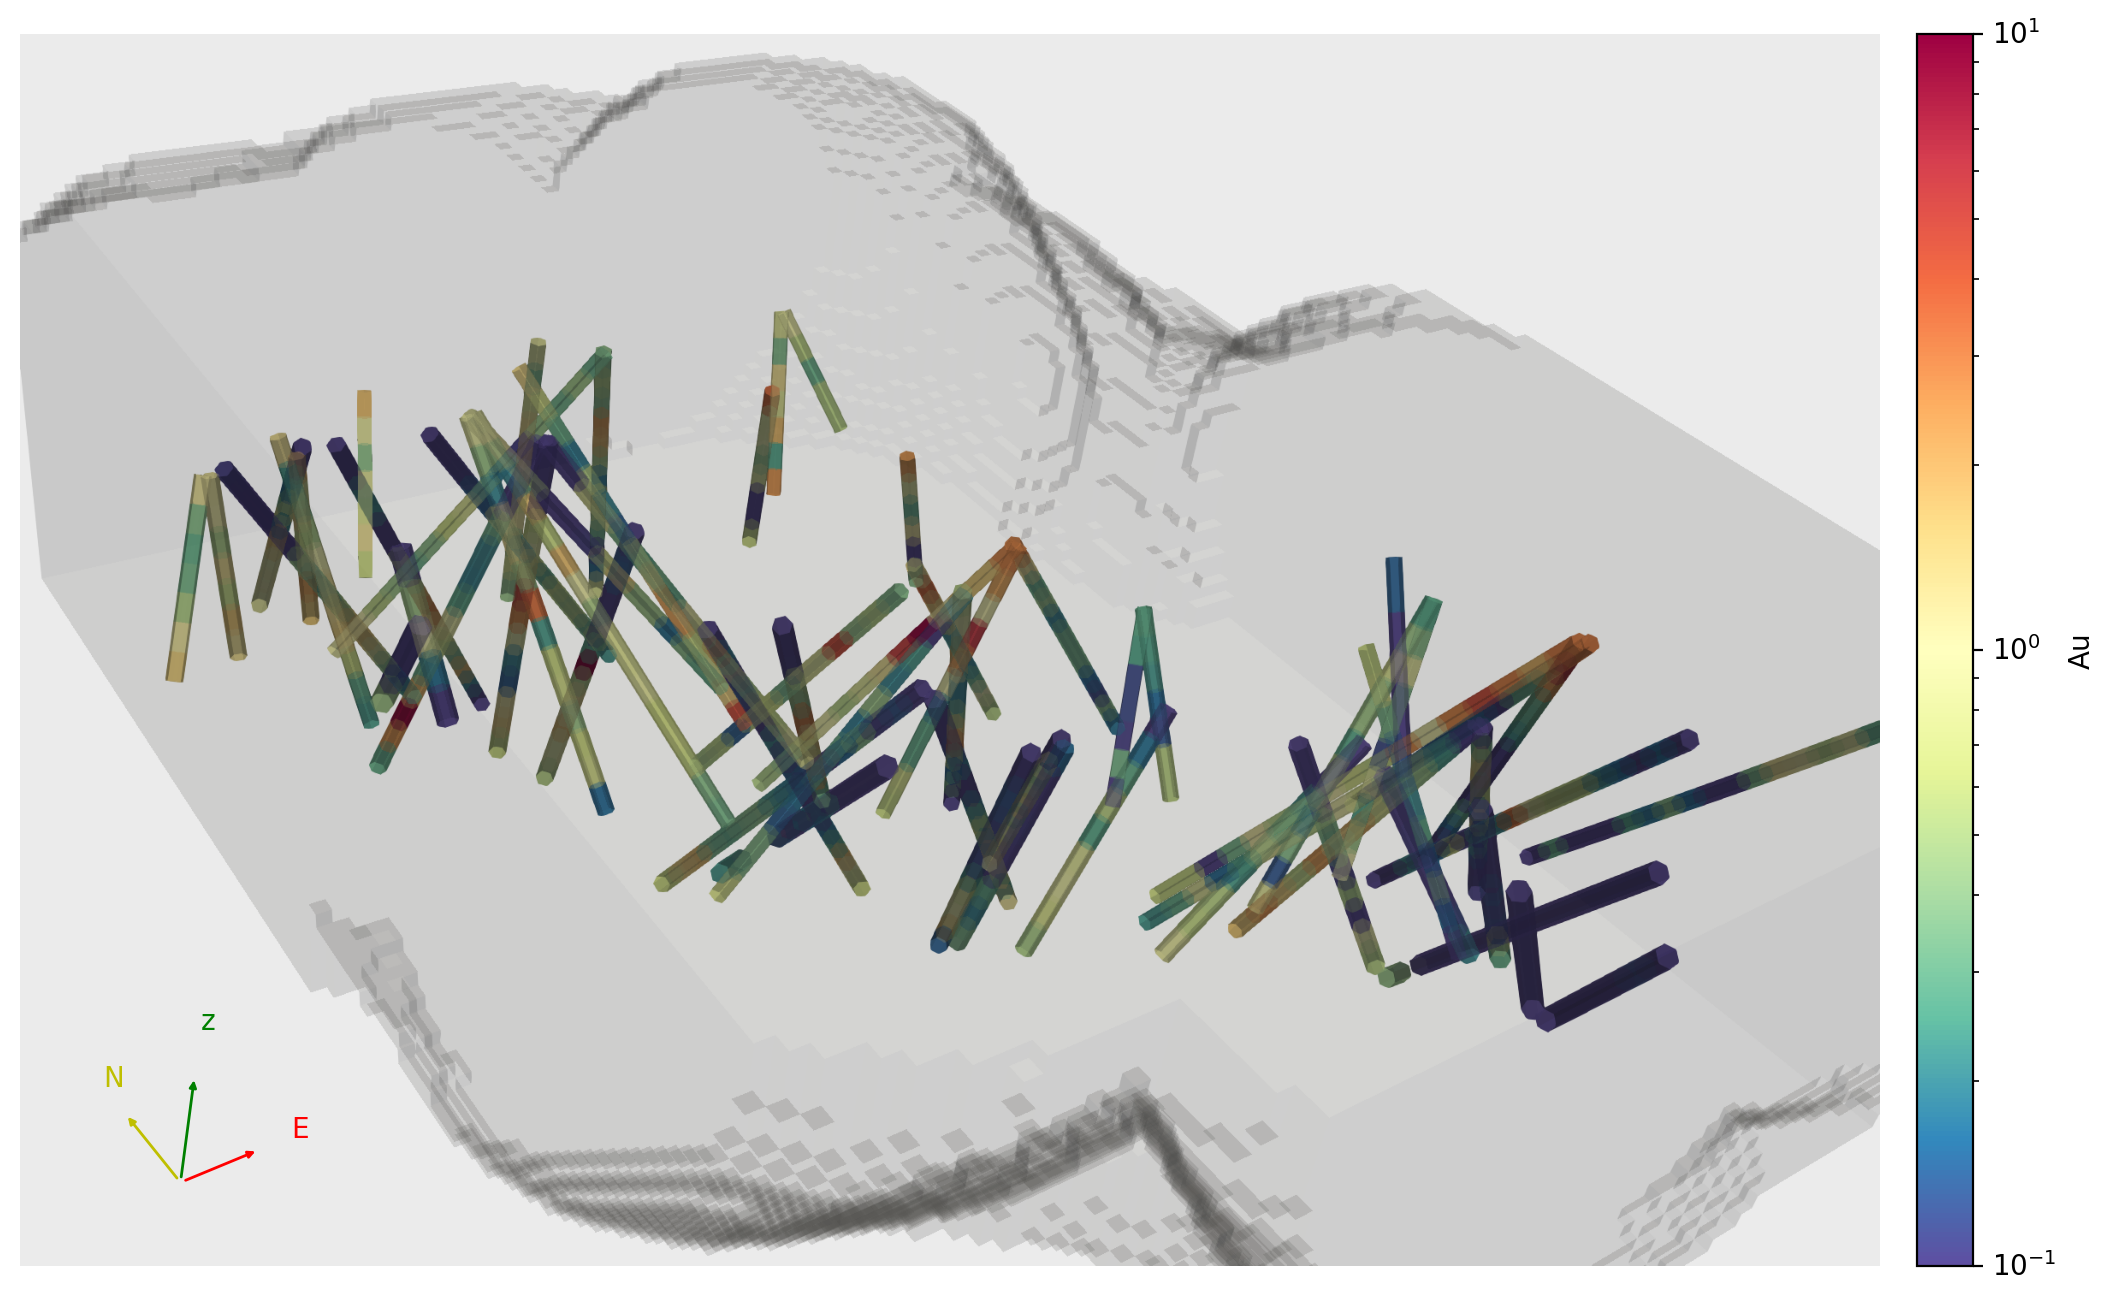

In [9]:
viewer = grids.view3d(alpha=0.1, color="0.5")
data.view3d(au.col, representation="Surface", viewer=viewer)
viewer.set_camera(view_matrix)

## Decluster

Decluster using the IDW estimator. NN declustering and cell declustering are other popular options.

In [10]:
search = rmsp.Search(ranges=[200.0, 200.0, 100.0], min_comps=1, max_comps=20)
idw = rmsp.IDWEstimator().set_params(search, power=2, reg_const=0.1)
data["wt"] = rmsp.DeclusterEstimator(idw).decluster(grids, data, au.col)

Plot a 3D view of the weights. Composites lying on the edge of blocks have higher weights because they are used more in the IDW estimation.

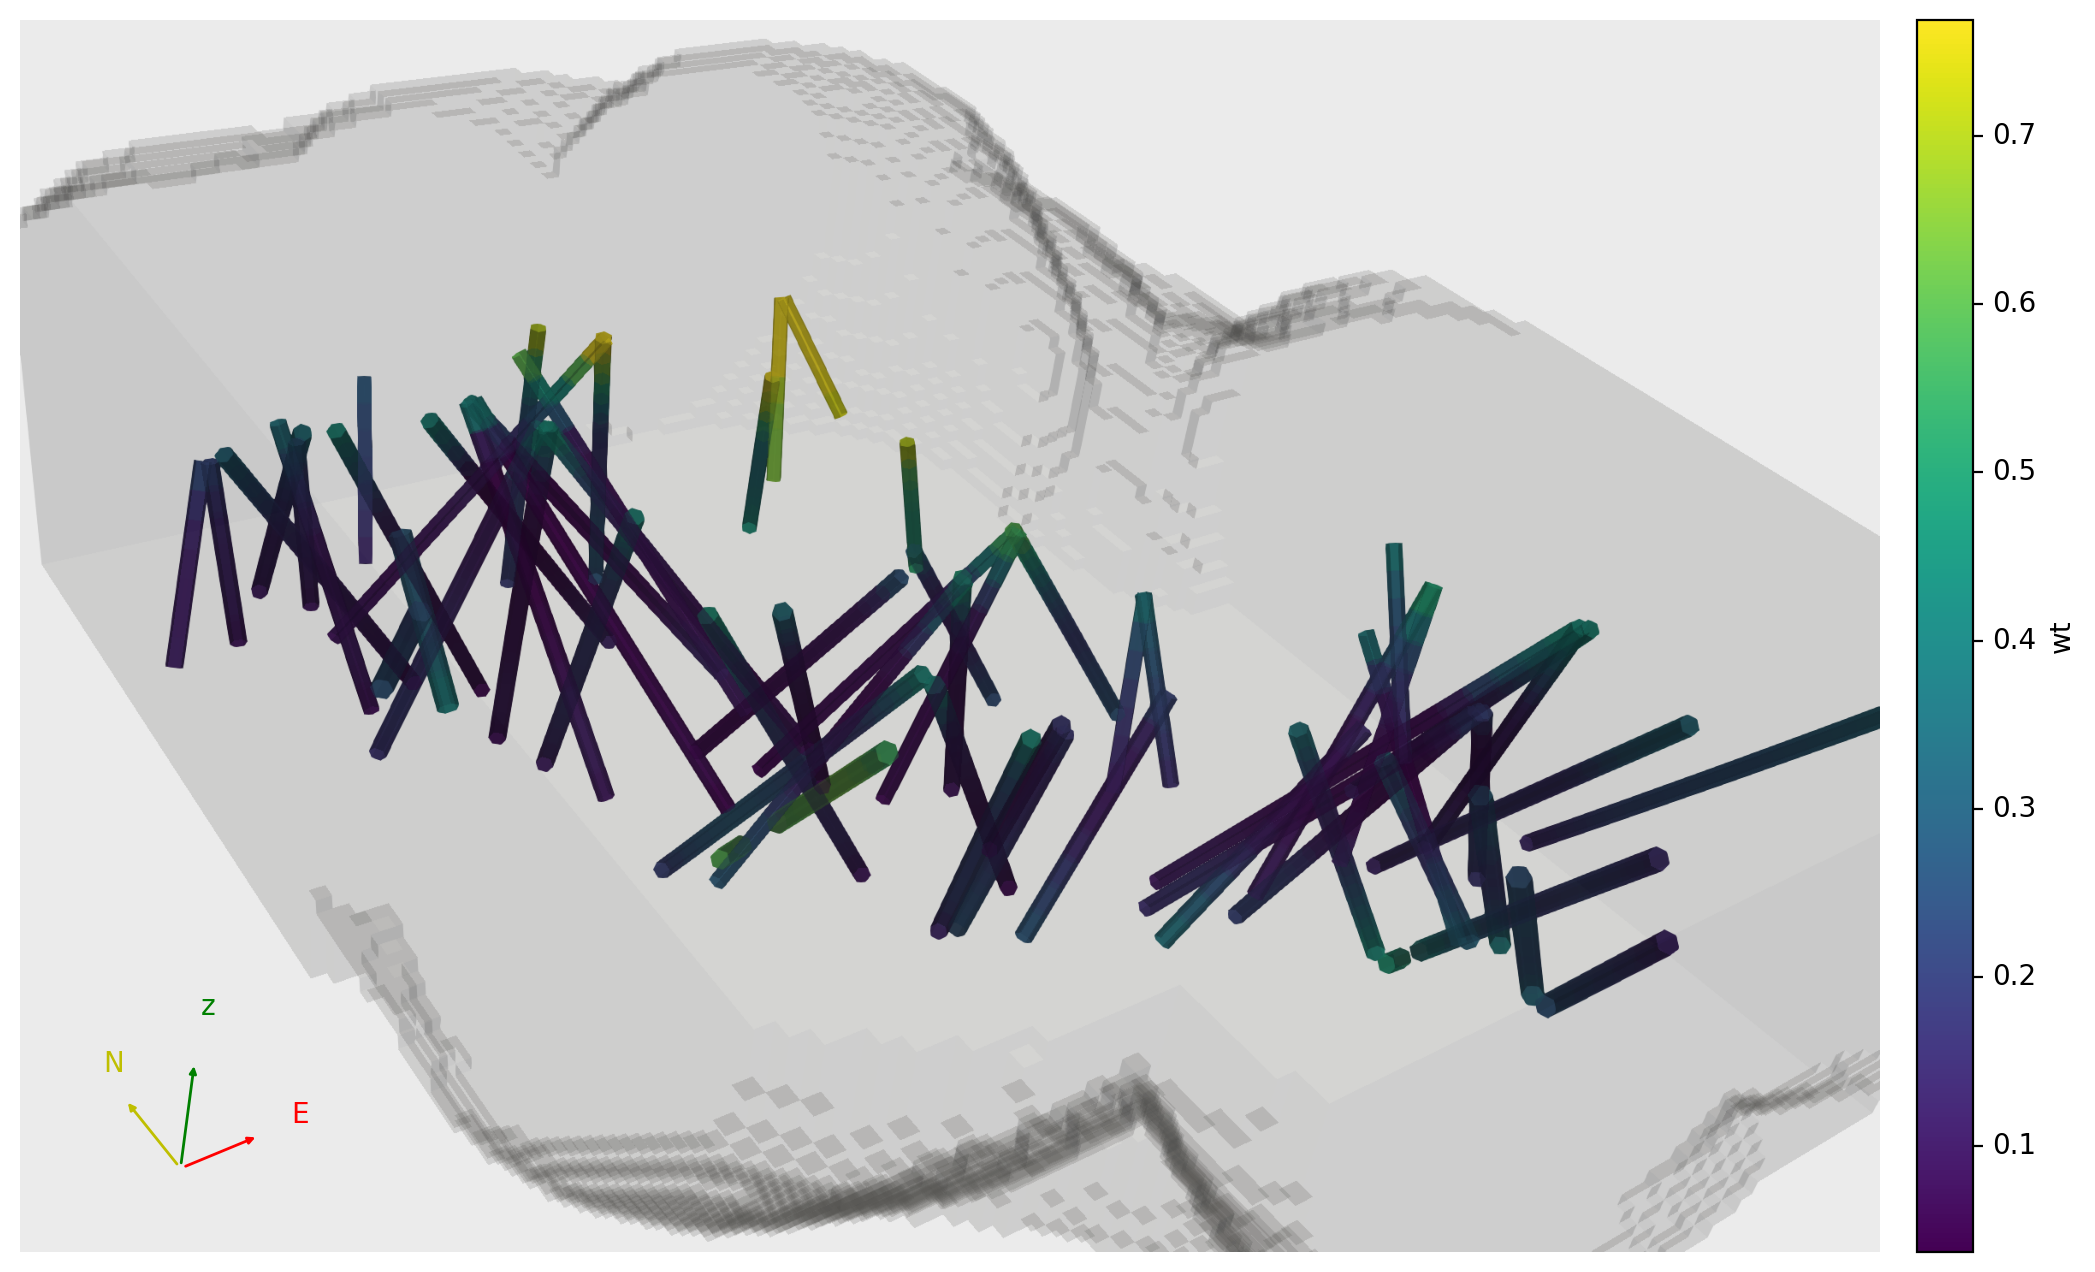

In [11]:
viewer = grids.view3d(alpha=0.1, color="0.5")
data.view3d("wt", representation="Surface", viewer=viewer)
viewer.set_camera(view_matrix)

Comparing clustered and declustered CDFs. The declustered distribution has a lower mean as drilling is spatially biased in higher-grade regions.

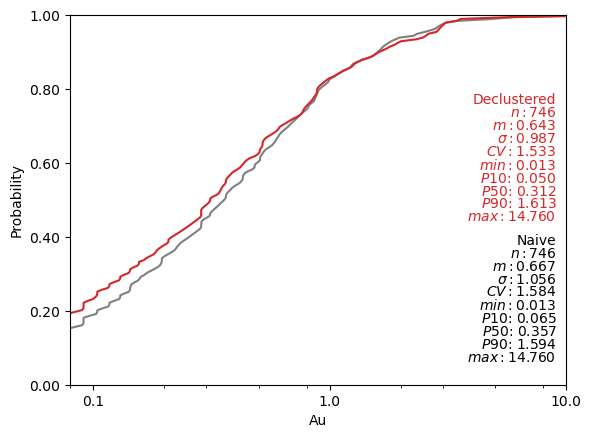

In [12]:
fig, ax = data.cdfplot(au.col, stats_label="Naive")
data.cdfplot_draw(
    ax,
    au.col,
    "wt",
    stats_label="Declustered",
    c="C3",
    stats_c="C3",
    stats_loc=(0.98, 0.4),
)

## Despike

Despike using random and spatial despiking. Values below the practical detection limit of this data are set to 0.08, leading to a significant spike that will more clearly show downstream impacts of spatial vs. random despiking.

Spike:

In [13]:
data.loc[data[au] < 0.08, au] = 0.08

Spatial despiking considers a local neighbourhood to rank the data with the same value. With spatial despiking, high local averages rank higher, where random despiking ranks the data randomly. This different ranking leads to different Gaussian values after transformation. Intuitively, spatial despiking will have more spatial continuity, though it should not be excessive. This increased spatial continuity is controlled through adding a random component, and can be observed in the variogram plotting in the following sections. 

Setting `wt_to_random=1` means the despiking values are purely random:

In [14]:
dsp_rd = rmsp.DespikeSpatial(wt_to_random=1)
data[au_rd] = dsp_rd.fit_transform(data, au.col)

Alternatively, setting `wt_to_random=0.5` means the despiking values are half-weighted towards a spatial moving window average based on `num_neighbours`, providing spatial structure:

In [15]:
dsp = rmsp.DespikeSpatial(wt_to_random=0.5, num_neighbors=10)
data[au_sd] = dsp.fit_transform(data, au.col)

The spike values and counts are listed below. Note that the majority of spikes are at the imposed detection limit, which is typical.

In [16]:
pd.DataFrame(data.loc[dsp.spike_indices, au.col].value_counts())

,count
Au,
0.08000,117
0.09100,13
0.28613,12
0.14313,11
0.10413,11
...,...
0.53313,2
1.27413,2
0.76713,2


Also note that the despiked values remain consistent to the third decimal place, as the default `spike_epsilon=0.0001` is used above (this could be adjusted).

In [17]:
cols = [au, au_rd, au_sd]
data.loc[dsp.spike_indices, cols].head()

,Au,Au with Random Despiking,Au with Spatial Despiking
0,0.080,0.080037,0.080053
1,0.091,0.091018,0.091043
3,0.364,0.364001,0.364022
4,0.481,0.481060,0.481064
5,0.806,0.806097,0.806073


Observe that (despite local differences shown above), the original unit distribution statistics are identical regardless of chosen method:

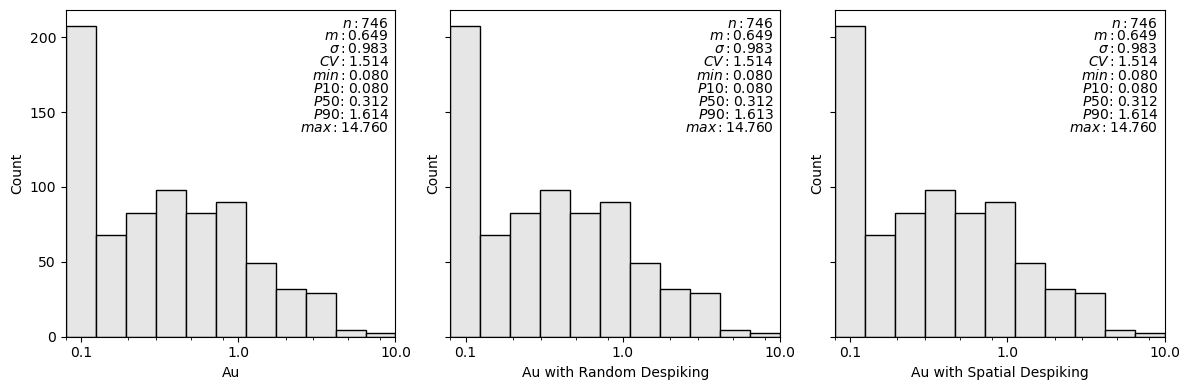

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for col, ax in zip(cols, axes):
    data.histplot(col, ax=ax, wt="wt")
fig.tight_layout()

---
# Normal Score Transform with Each Despiking Approach

The data is normal score (NS) transformed data using the two different despiking methods, storing the transformed dataset in two columns. Note that declustering weights are used here. Two `rmsp.NSTransformer()` objects are retained, `nst_rd` (random despiking) and `nst_sd` (spatial despiking), to facilitate two different back transforms.

In [19]:
nst_rd = rmsp.NSTransformer()
data[ns_rd] = nst_rd.fit_transform(data[au_rd], data["wt"])

nst_sd = rmsp.NSTransformer()
data[ns_sd] = nst_sd.fit_transform(data[au_sd], data["wt"])

## Compare local values
Collect the normal score and despiking variables in a list for iteration.
Glancing at the first five records, observe that virtually identical values in original units (distinguished by their spikes beyond the third decimal) are associated with markedly larger differences in Gaussian units:

In [20]:
cols = [au_rd.col, au_sd.col, ns_rd.col, ns_sd.col]
data[cols].head()

,Au with Random Despiking,Au with Spatial Despiking,NS Au with Random Despiking,NS Au with Spatial Despiking
0,0.080037,0.080053,-1.377574,-1.170852
1,0.091018,0.091043,-0.835942,-0.819434
2,0.988000,0.988000,0.937124,0.937124
3,0.364001,0.364022,0.108678,0.111542
4,0.481060,0.481064,0.301315,0.302046


## Compare distributions

Despite those larger local differences, however, the transformed distributions are both $N(0,1)$.

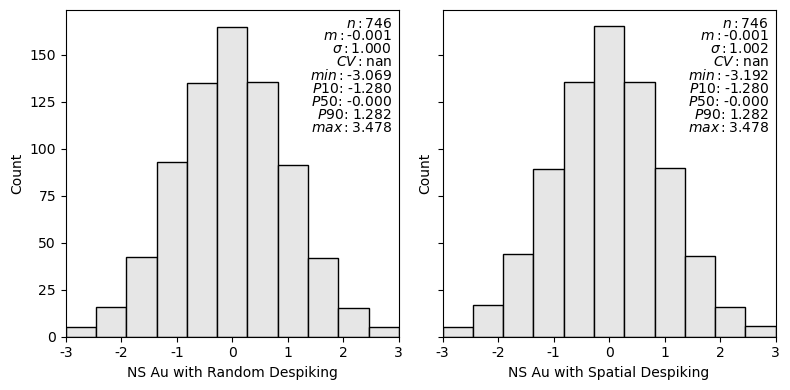

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
for col, ax in zip(cols[2:], axes):
    data.histplot(col, ax=ax, wt="wt")
fig.tight_layout()

## Compare variograms

Calculate experimental variograms with the normal scores of each despiking method. Omni-directional variograms are used here for brevity.

In [22]:
search = rmsp.ExpVarioSearch(
    azm=0,
    incl=0,
    lagdists=rmsp.Lags(20, 10, 10),
    azmtol=90.0,  # omni-directional
    incltol=90.0,  # omni-directional
)
expvario_rd = rmsp.ExpVario().calculate(data, ns_rd, search)
expvario_sd = rmsp.ExpVario().calculate(data, ns_sd, search)

Plot the variograms. As expected, spatially despiked data is more continuous than random.

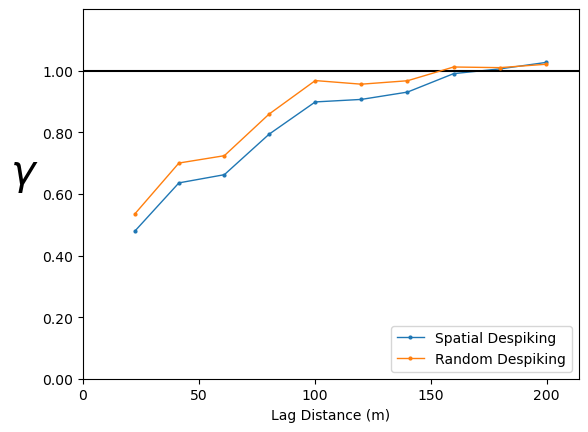

In [23]:
fig, ax = expvario_sd.plot(label="Spatial Despiking", ls="-")
expvario_rd.plot_draw(ax, label="Random Despiking", ls="-")
_ = ax.legend(loc=4)

Not related to the main focus of this section (demonstrating the impact of despiking on normal scores), but to facilitate simulation in the next section, fit a variogram model to the spatially despiked variogram (considered the more representative).

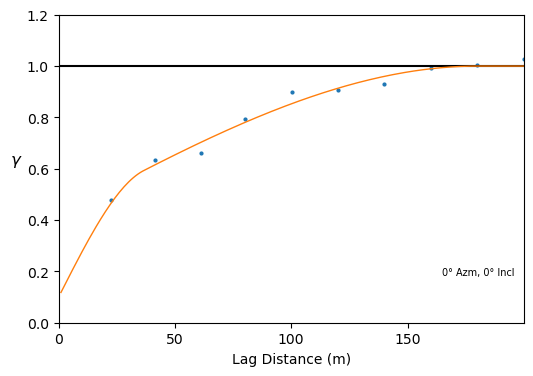

In [24]:
variomodel = rmsp.VarioModel.fit_experimental(
    expvario_sd, num_struct=2, ranges12_bounds=1, ranges13_bounds=1, nugget=0.1
)
_ = expvario_sd.gridplot(model=variomodel, figsize=(6, 4))

---
# Simulation and KDE Smoothing

Piecewise linear (stepped) CDF artifacts occur in simulated realizations when the normal score transform is defined using an empirical CDF that is based on sparse data. These artifacts are demonstrated in the first sub-section that follows, using the normal score transform defined in the preceding section. These artifacts can be addressed by defining the normal score transform with a smoothed KDE distribution that is fit to the empirical CDF, as demonstrated in the second sub-section.

## Demonstration of the artifacts


Number of realizations to simulate:

In [25]:
num_reals = 25

Simulate using the Gaussian transformed data that considered spatial despiking. No KDE smoothing is applied in this first step. An isotropic search and omni-directional variogram model are used for simplicity. In practice the search orientation and anisotropy could be informed by the fitted variogram model. 

In [26]:
search = rmsp.Search.from_vario_buffer(variomodel, max_comps=40)
simcache = rmsp.Simulator(copy_meta=True).simulate(
    locations=grids,
    data=data,
    var=ns_sd.col,
    search=search,
    vario=variomodel,
    reals=num_reals,
    cache_var=ns_sd.col,
)
simcache

                                               Value
Realization Length                           262,730
Number of Realizations                            25
Min Realization Index                              0
Max Realization Index                             24
Variable 0              NS Au with Spatial Despiking
Storage Mode                                  memory
Keyout                                         False
Nested Keyout                                  False

Inverse the normal score transform:

In [27]:
simcache = nst_sd.inverse_transform_sim(simcache, ns_sd.col, simcache, au.col)

Calculate realization statistics and plot CDFs. The code is wrapped in a function for re-use in the next section. Observe the 'stepped' piecewise linear artifacts, particularly in the lower tail. These would grow even more prominent with fewer that the 746 data used here, and/or when more extreme declustering weights are present (consider that the vertical steps correspond with weight of each datum).

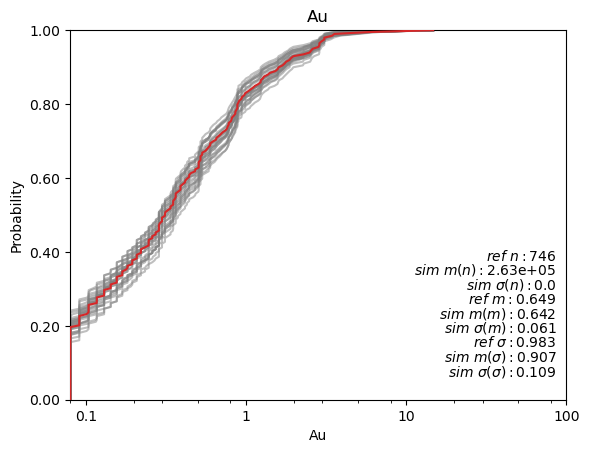

In [28]:
def plot_sim_stats(simcache, var):
    sim_unistats = [
        rmsp.UniStats(real[var]) for _, real in simcache.iter_realizations()
    ]
    refstats = (
        kde.to_unistats() if var == au_kde else rmsp.UniStats(data[var], data["wt"])
    )
    _ = refstats.cdfplot_checkreals(sim_unistats, title=var, xlim=(0.08, 100),sigdigs=3)


plot_sim_stats(simcache, au.col)

## KDE Smoothing

Fit a univariate KDE to the data CDF, smoothing the stepped artifacts.

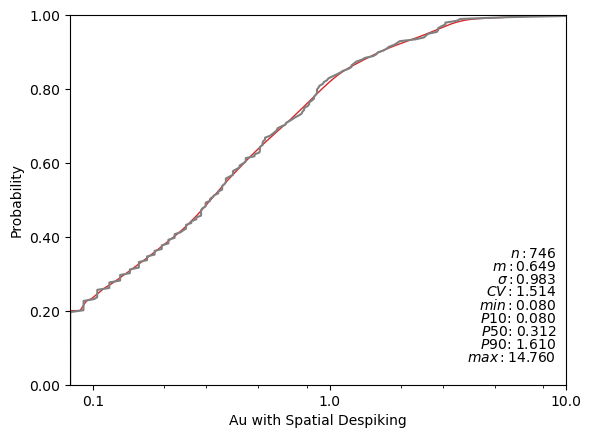

In [29]:
kde = rmsp.UnivariateKDE(data=data, var=au_sd.col, wt="wt", log=True, bandwidth=0.4)
fig, ax = kde.plot(xlim=(0.0801, 10))

Use KDE distribution to define/fit NS transformation. Note the difference from the previous step: the `rmsp.NSTransformer()` is fitted to the KDE reference distribution rather than directly to the data.

In [30]:
kdetrans = rmsp.NSTransformer().fit(unistats=kde.to_unistats())
data[ns_kde] = kdetrans.transform(data[au_sd], data["wt"])

Simulate, where the only changing parameter is the conditioning data column. Parameters such as the variogram model are not expected to significantly shift due to the empirical CDF vs. KDE-smoothed normal score transformation:

In [31]:
simcache = rmsp.Simulator(copy_meta=True).simulate(
    locations=grids,
    data=data,
    var=ns_kde.col,
    search=search,
    vario=variomodel,
    reals=num_reals,
    cache=simcache,
    cache_var=ns_kde.col,
)
simcache

                                               Value
Realization Length                           262,730
Number of Realizations                            25
Min Realization Index                              0
Max Realization Index                             24
Variable 0              NS Au with Spatial Despiking
Variable 1                                        Au
Variable 2                            NS Au with KDE
Storage Mode                                  memory
Keyout                                         False
Nested Keyout                                  False

Inverse the normal score transform:

In [32]:
simcache = kdetrans.inverse_transform_sim(simcache, ns_kde.col, simcache, au_kde.col)

Calculate realization statistics and plot using the previously defined function. Comparing to the prior section's result, observe that the artifacts are mitigated by KDE smoothing.

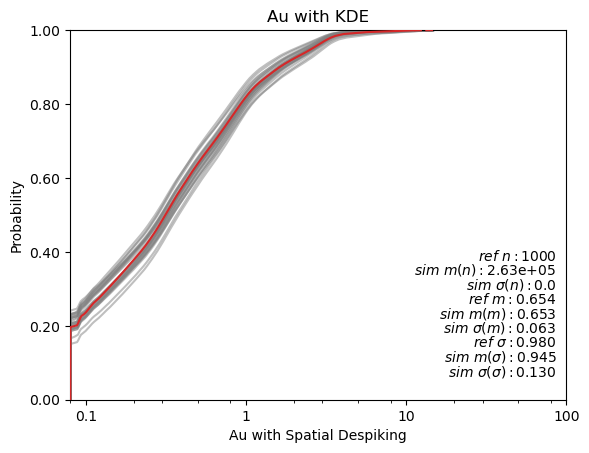

In [33]:
plot_sim_stats(simcache, au_kde.col)

--- 
# Closing Comments

This notebooks demonstrates the workflow of transforming data to a normal score distribution. The key preprocessing steps are declustering and despiking, which yield a representative and spike-free CDF for defining the transformation. A blended despiking approach considering both random and locally neighbourhood components is recommended. The spatial neighbourhood ensures higher local averages rank higher during depsiking, and the random component ensures excessive artifical continuity is not introduced. The importance of this has been demonstrated, as the despiking implementation was shown to have a large impact on continuity in normal scores.  The normal score transform of a CDF with piecewise linear features can lead to stepped or "jagged" artifacts when back transforming. This can be mitgated by fitting a KDE to the empirical CDF and transforming the data using the smoothed reference distribution, as demonstrated.

---

<footer>
<div style="text-align:center">    
    <p style="text-align:center; color:#00797C"> Partners: </p>
    <a href="https://resourcemodelingsolutions.com"><img class="rs" style="max-width:200px;"    src="https://geostatisticslessons.com/images/icons/resource_modeling_solutions_logo.png">
    </a>
    <a  href="https://geostatisticslessons.com/termsofuse"> <p style="text-align:center; color:#00797C">  Terms of Use </p></a>
    <a href="mailto:contact@resmodsol.com"> <p style="text-align:center; color:#00589d">Contact Resource Modeling Solutions about a commercial or academic license for RMSP</p> </a>
</div>
</footer>